In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# Model
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import export_graphviz
# import graphviz

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score ,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection
from sklearn.preprocessing import Binarizer

In [3]:
df_good = pd.read_csv('./dataset/data_확장기.csv')
df_bad = pd.read_csv('./dataset/data_수축기.csv')
df_change = pd.read_csv('./dataset/data_전환기.csv')
df_all = pd.read_csv('./dataset/data_전체.csv')

df_good.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_bad.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_change.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_all.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)

#### 함수

##### train, test 분리, 데이터 불균형 처리, 스케일링

In [4]:
def data(df):
    # scaler : StandardScaler(), RobustScaler()

    features = df.drop(['target'], axis=1)
    target = df['target']

    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=121, stratify=target, test_size=0.2)
    
    # X_train, y_train = RandomUnderSampler(random_state=121).fit_resample(X_train, y_train)
    # X_train, y_train = TomekLinks(sampling_strategy = 'not majority').fit_resample(X_train, y_train) # not majority(Good), majority, all
    # X_train, y_train = OneSidedSelection(sampling_strategy = 'auto', random_state=0, n_neighbors=1).fit_resample(X_train, y_train)

    # X_train, y_train = BorderlineSMOTE(random_state=121, sampling_strategy = 'not majority').fit_resample(X_train, y_train)
    X_train, y_train = ADASYN(random_state=121).fit_resample(X_train, y_train)
    # X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state=121).fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

##### 모델 평가

In [5]:
def score(y_test, pred):
    
    print('accuracy score : {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('precision score : {0:.3f}'.format(precision_score(y_test, pred)))
    print('recall score : {0:.3f}'.format(recall_score(y_test, pred)))
    print('f1 score : {0:.3f}'.format(f1_score(y_test, pred)))
    print('roc score : {0:.3f}'.format(roc_auc_score(y_test, pred)))
    
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='YlOrBr', fmt='g')
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)

In [6]:
def get_f1_score(y_test, pred_proba_1):
    thresholds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores=[]

    for threshold in thresholds:
        binarizer = Binarizer(threshold = threshold)
        pred_proba = binarizer.fit_transform(pred_proba_1)

        accuracy = accuracy_score(y_test, pred_proba)
        precision = precision_score(y_test, pred_proba)
        recall = recall_score(y_test, pred_proba)
        f1score = f1_score(y_test, pred_proba)
        auc_score=roc_auc_score(y_test, pred_proba)

        accuracys.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1score)
        auc_scores.append(auc_score)
    results = pd.DataFrame(data = {"Accuracy": accuracys, "Precision": precisions, "Recall": recalls, "F1 score": f1_scores,"Auc_Score":auc_scores}, index = thresholds)
    print(results)

##### 모델링

In [7]:
def LR(df):
    X_train, X_test, y_train, y_test = data(df)

    logistic = LogisticRegression()

    param_logit = {'penalty' : ['l1', 'l2'],
                   'C' : [0.001, 0.01, 0.1, 1, 10, 100],
                   'solver' : ['liblinear'],
                   'random_state' : [121],
                   'class_weight' : ['balanced']}

    gridsearch = GridSearchCV(logistic, param_grid = param_logit, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))


    # model_coef = pd.Series(best_model.best_estimator_.regressor_.coef_[0], df.drop(['target']).columns).sort_values(ascending=False)
    # model_coef

In [8]:
def DT(df):
    X_train, X_test, y_train, y_test = data(df)

    dt = DecisionTreeClassifier()
    param_dt = { 'criterion' : ['entropy'],   #giny : 속도 더 빠름, #엔트로피 : 균형적인 트리
                    'splitter' : ['best'],
                    'random_state' : [121],
                    'max_depth' : [5, 6, 7],
                    'min_samples_split' : [3, 5],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(dt, param_grid = param_dt, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

    return gridsearch.fit(X_train, y_train)

In [9]:
def SVM(df, kernel):
    X_train, X_test, y_train, y_test = data(df)

    svc = SVC()
    param_svc = {'C' : [0.1, 0.5, 1.0],
                    'kernel' : [kernel],
                    'gamma' : [0.01, 0.1, 1.0, 10.0],
                    'random_state' : [121],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(svc, param_grid = param_svc, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    pred = estimator.predict(X_test)
    # pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    # prediction = pd.concat([pred_probability, pred], axis = 1)
    # prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    # pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    # print(get_f1_score(y_test, pred_proba_1))

In [10]:
def XGB(df):
    X_train, X_test, y_train, y_test = data(df)

    xgb = XGBClassifier()
    param_xgb={'booster' :['gbtree'],
               'silent' : [1],
               'verbosity' : [0],
               'learning_rate' : [0.01, 0.05, 0.1],    # 나중에 한 번 더 확인
               'n_estimators' : [500],
               'min_child_weight' : [3, 5, 7],  ###
               'gamma' : [0.1, 1.0, 10.0],    ###
               'max_depth' : [4, 6],     ###
               'objective':['binary:logistic'],
               'colsample_bytree' : [0.6, 0.8],
               'colsample_bylevel' : [0.6, 0.8],
               'random_state' : [121],
               'scale_pos_weight' : [ len(df[df['target']==0])/len(df[df['target']==1]) ]
                }

    gridsearch = GridSearchCV(xgb, param_grid = param_xgb, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)
    
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

#### Feature Selection

In [11]:
rfe_good = df_good[['유동비율', 'OCF', '총자본경상이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '유형자산증가율', '순이익증가율', 'target']]
sfm_rf_good = df_good[['부채비율', 'OCF', '총자산이익률', '총자본경상이익률', '자기자본순이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '순이익증가율', 'target']]
sfm_lr_good = df_good[['자기자본비율', '차입금의존도', '총자산이익률', '총자본경상이익률', '자기자본영업이익률', '매출원가율', '총자본회전율', '총자본증가율', '유형자산증가율', 'target']]
sfm_pi_good = df_good[['자기자본영업이익률', '총자본회전율', '총자산이익률', '총자본경상이익률', '순이익증가율', '자기자본회전율', '유동비율', 'OCF', 'target']]

In [12]:
rfe_bad = df_bad[['유동비율', 'OCF', '총자본경상이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', 'target']]
sfm_rf_bad = df_bad[['부채비율', 'OCF', '총자산이익률', '총자본경상이익률', '자기자본순이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '순이익증가율', 'target']]
sfm_lr_bad = df_bad[['자기자본비율', '유동비율', '차입금의존도', '자기자본영업이익률', '매출원가율', '총자본회전율', '자기자본회전율', '총자본증가율', '유형자산증가율', 'target']]
sfm_pi_bad = df_bad[['자기자본영업이익률', '총자본회전율', '총자본경상이익률', '총자산이익률', '순이익증가율', '자기자본회전율', '유동비율', 'OCF', 'target']]

#### 확장기

##### Recursive Feature Elimination

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.858821068778078

예측 데이터 정확도
accuracy score : 0.808
precision score : 0.339
recall score : 0.863
f1 score : 0.487
roc score : 0.832
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.55449    0.18877 0.97616   0.31636    0.74043
0.30000   0.66525    0.23388 0.95358   0.37563    0.79239
0.40000   0.74925    0.28557 0.91531   0.43533    0.82248
0.50000   0.80815    0.33934 0.86261   0.48707    0.83216
0.60000   0.84498    0.38380 0.77290   0.51291    0.81320
0.70000   0.86505    0.40674 0.60602   0.48677    0.75083
0.80000   0.86870    0.38369 0.40151   0.39240    0.66268
0.90000   0.87645    0.35752 0.21330   0.26719    0.58402
None


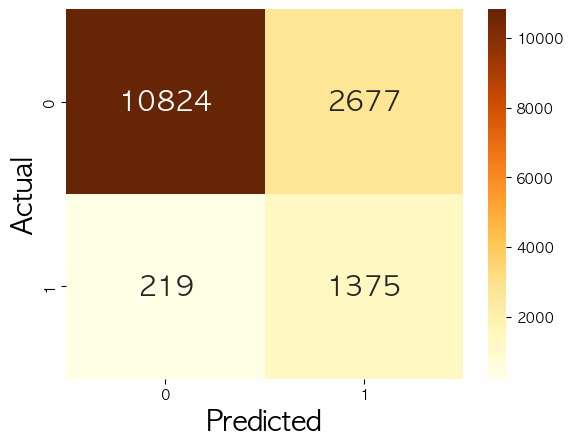

In [13]:
LR(rfe_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9203526515836306

예측 데이터 정확도
accuracy score : 0.872
precision score : 0.448
recall score : 0.924
f1 score : 0.604
roc score : 0.895
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.84266    0.39902 0.96801   0.56510    0.89793
0.30000   0.85028    0.41058 0.95922   0.57503    0.89832
0.40000   0.86896    0.44299 0.93601   0.60137    0.89853
0.50000   0.87181    0.44813 0.92409   0.60356    0.89486
0.60000   0.87658    0.45242 0.80238   0.57860    0.84386
0.70000   0.88036    0.46131 0.79297   0.58329    0.84182
0.80000   0.88943    0.48150 0.61230   0.53908    0.76723
0.90000   0.90209    0.54596 0.43225   0.48249    0.69490
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

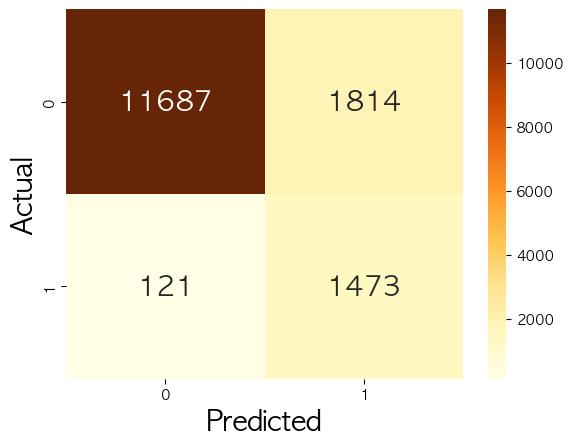

In [14]:
DT(rfe_good)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.9259265406079052

예측 데이터 정확도
accuracy score : 0.878
precision score : 0.458
recall score : 0.831
f1 score : 0.590
roc score : 0.857


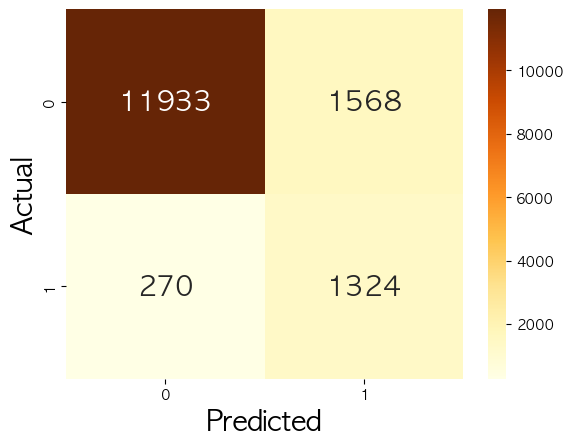

In [15]:
SVM(rfe_good, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.467385850476669, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.9240459208926964

예측 데이터 정확도
accuracy score : 0.868
precision score : 0.441
recall score : 0.932
f1 score : 0.599
roc score : 0.896
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.84730    0.40701 0.97616   0.57449    0.90412
0.30000   0.85426    0.41744 0.96110   0.58207    0.90137
0.40000   0.85949    0.42550 0.94417   0.58663    0.89683
0.50000   0.86810    0.44105 0.93162   0.59867    0.89611
0.60000   0.87466    0.45314 0.90402   0.60369    0.88760
0.70000   0.88188    0.46838 0.87829   0.61095    0.88030
0.80000   0.88990    0.48744 0.82811   0.61367    0.86265
0.90000   0.90235    0.52715 0.73087   0.61251    0.82673
None


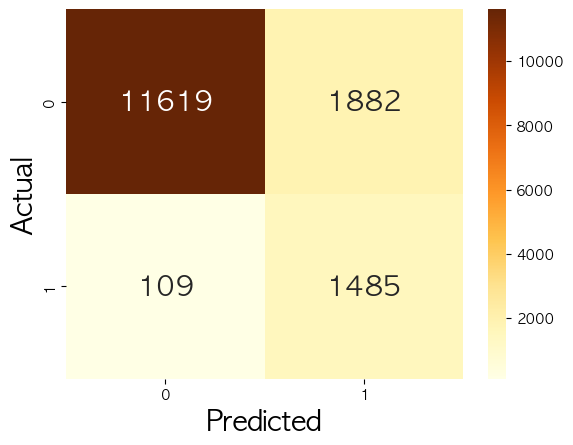

In [16]:
XGB(rfe_good)

##### SelectFromModel_RandomForest

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8590264300946716

예측 데이터 정확도
accuracy score : 0.805
precision score : 0.337
recall score : 0.870
f1 score : 0.485
roc score : 0.834
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.55204    0.18770 0.97428   0.31475    0.73823
0.30000   0.66201    0.23205 0.95295   0.37322    0.79030
0.40000   0.74309    0.28156 0.92346   0.43155    0.82263
0.50000   0.80523    0.33665 0.87014   0.48547    0.83385
0.60000   0.84617    0.38696 0.78168   0.51766    0.81773
0.70000   0.86565    0.40898 0.61167   0.49020    0.75365
0.80000   0.87115    0.39331 0.40590   0.39951    0.66599
0.90000   0.87797    0.36638 0.21330   0.26963    0.58487
None


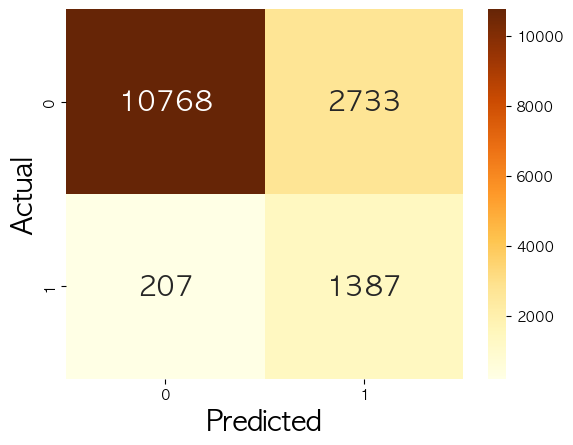

In [17]:
LR(sfm_rf_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9184902174868276

예측 데이터 정확도
accuracy score : 0.878
precision score : 0.459
recall score : 0.880
f1 score : 0.603
roc score : 0.879
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.84975    0.40970 0.95922   0.57416    0.89802
0.30000   0.85141    0.41237 0.95797   0.57655    0.89840
0.40000   0.85419    0.41510 0.93099   0.57419    0.88806
0.50000   0.87791    0.45922 0.87955   0.60340    0.87863
0.60000   0.88122    0.46443 0.81493   0.59166    0.85199
0.70000   0.88023    0.45837 0.73902   0.56580    0.81796
0.80000   0.89109    0.48899 0.69636   0.57453    0.80522
0.90000   0.89758    0.51274 0.60602   0.55549    0.76901
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

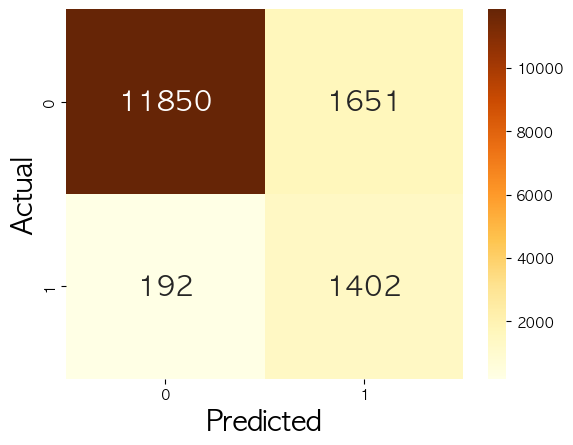

In [18]:
DT(sfm_rf_good)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.9283599491526212

예측 데이터 정확도
accuracy score : 0.882
precision score : 0.468
recall score : 0.837
f1 score : 0.600
roc score : 0.862


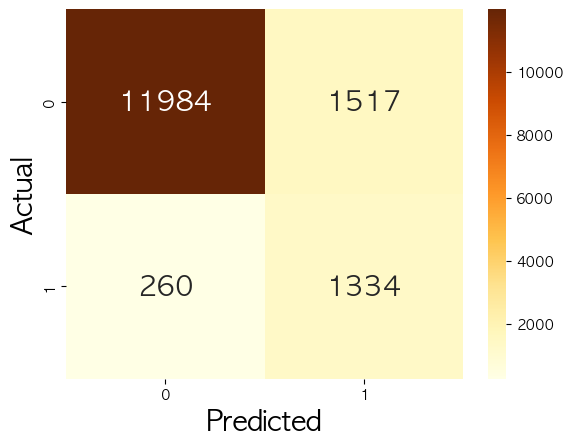

In [19]:
SVM(sfm_rf_good, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.467385850476669, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.9236507180191182

예측 데이터 정확도
accuracy score : 0.865
precision score : 0.435
recall score : 0.936
f1 score : 0.594
roc score : 0.896
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.84180    0.39841 0.97679   0.56598    0.90133
0.30000   0.85061    0.41156 0.96487   0.57700    0.90100
0.40000   0.85816    0.42354 0.95044   0.58596    0.89885
0.50000   0.86486    0.43499 0.93601   0.59395    0.89623
0.60000   0.87274    0.44965 0.91593   0.60318    0.89179
0.70000   0.88036    0.46504 0.88457   0.60960    0.88221
0.80000   0.89003    0.48806 0.84630   0.61909    0.87075
0.90000   0.90262    0.52790 0.73588   0.61478    0.82909
None


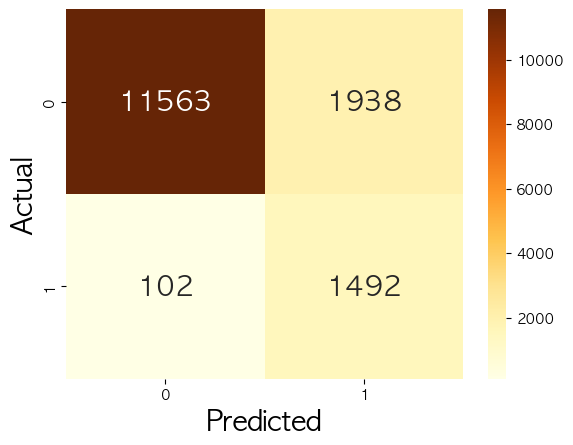

In [20]:
XGB(sfm_rf_good)

##### SelectFromModel_Logistic Regression

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.825864023318721

예측 데이터 정확도
accuracy score : 0.799
precision score : 0.328
recall score : 0.865
f1 score : 0.476
roc score : 0.828
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.49752    0.17237 0.98871   0.29356    0.71412
0.30000   0.63769    0.22134 0.96550   0.36013    0.78224
0.40000   0.73673    0.27715 0.92848   0.42688    0.82129
0.50000   0.79861    0.32802 0.86512   0.47568    0.82794
0.60000   0.84174    0.37574 0.75408   0.50156    0.80308
0.70000   0.85677    0.37445 0.53137   0.43932    0.71328
0.80000   0.86373    0.35189 0.34504   0.34843    0.63501
0.90000   0.87294    0.31591 0.17440   0.22474    0.56491
None


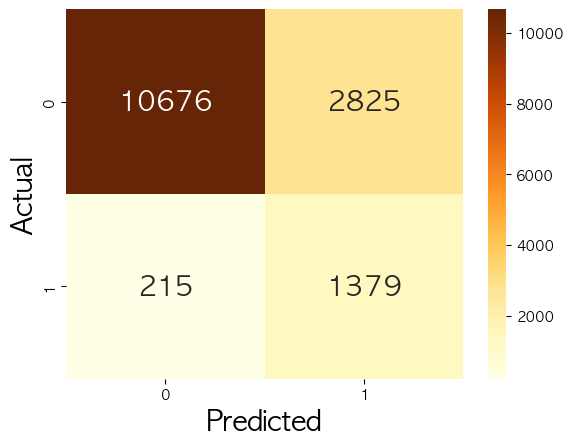

In [21]:
LR(sfm_lr_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9045483849706827

예측 데이터 정확도
accuracy score : 0.830
precision score : 0.380
recall score : 0.977
f1 score : 0.548
roc score : 0.895
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.81544    0.36374 0.99812   0.53318    0.89599
0.30000   0.81544    0.36374 0.99812   0.53318    0.89599
0.40000   0.81557    0.36347 0.99373   0.53226    0.89413
0.50000   0.82955    0.38046 0.97742   0.54772    0.89475
0.60000   0.83120    0.38170 0.96550   0.54710    0.89042
0.70000   0.83213    0.38244 0.95922   0.54685    0.88817
0.80000   0.87691    0.45129 0.76725   0.56831    0.82856
0.90000   0.90964    0.62610 0.35822   0.45571    0.66648
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

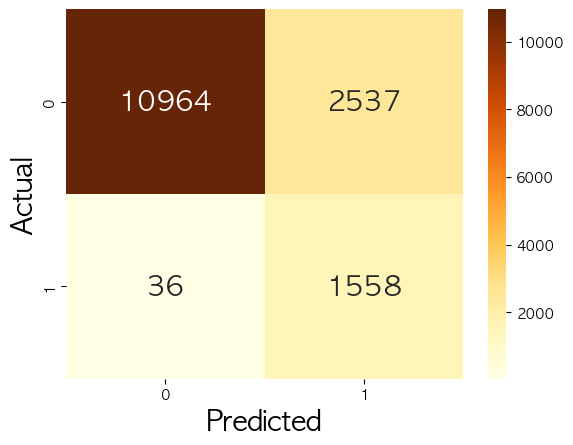

In [22]:
DT(sfm_lr_good)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.915152183298838

예측 데이터 정확도
accuracy score : 0.854
precision score : 0.407
recall score : 0.829
f1 score : 0.546
roc score : 0.843


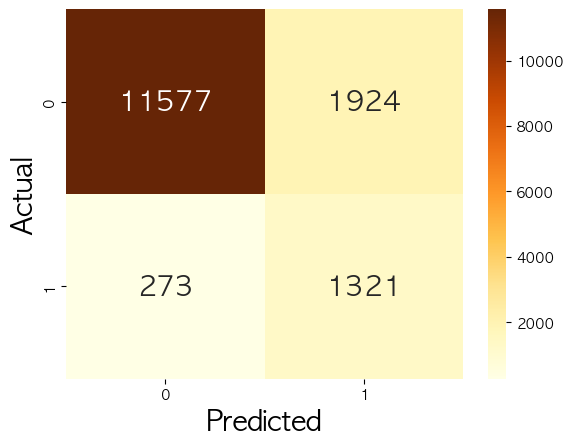

In [24]:
SVM(sfm_lr_good, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.467385850476669, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.9150062685890635

예측 데이터 정확도
accuracy score : 0.839
precision score : 0.393
recall score : 0.965
f1 score : 0.558
roc score : 0.894
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.82570    0.37669 0.99373   0.54630    0.89980
0.30000   0.82928    0.38085 0.98557   0.54940    0.89820
0.40000   0.83405    0.38678 0.97616   0.55403    0.89672
0.50000   0.83875    0.39275 0.96487   0.55826    0.89437
0.60000   0.84405    0.39984 0.95169   0.56310    0.89152
0.70000   0.85108    0.40947 0.92785   0.56819    0.88493
0.80000   0.86287    0.42870 0.89774   0.58029    0.87825
0.90000   0.87903    0.45827 0.79925   0.58253    0.84385
None


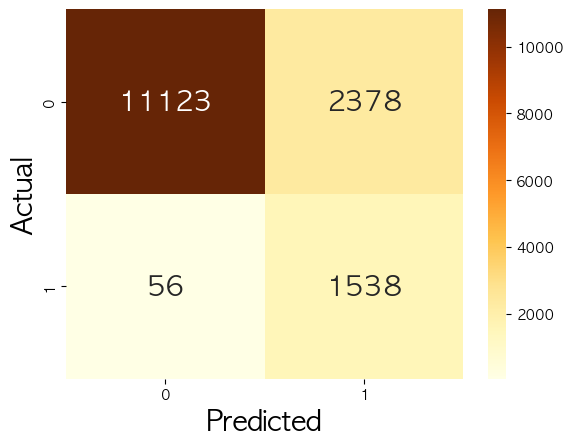

In [25]:
XGB(sfm_lr_good)

##### Permutation Importance

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8593263306923514

예측 데이터 정확도
accuracy score : 0.808
precision score : 0.339
recall score : 0.859
f1 score : 0.486
roc score : 0.830
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.55316    0.18816 0.97491   0.31544    0.73914
0.30000   0.66439    0.23284 0.94918   0.37395    0.78998
0.40000   0.74965    0.28524 0.91029   0.43437    0.82049
0.50000   0.80788    0.33853 0.85885   0.48563    0.83036
0.60000   0.84624    0.38637 0.77541   0.51575    0.81501
0.70000   0.86492    0.40655 0.60728   0.48704    0.75131
0.80000   0.86936    0.38669 0.40464   0.39546    0.66444
0.90000   0.87671    0.36251 0.22083   0.27446    0.58749
None


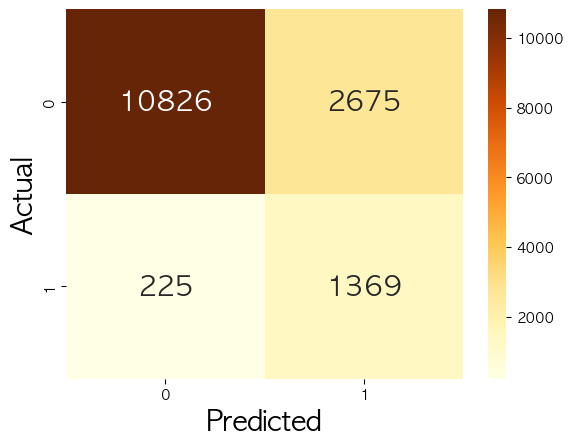

In [26]:
LR(sfm_pi_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9214896875508911

예측 데이터 정확도
accuracy score : 0.865
precision score : 0.433
recall score : 0.890
f1 score : 0.583
roc score : 0.876
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.84412    0.40063 0.95985   0.56531    0.89515
0.30000   0.85883    0.42426 0.94354   0.58533    0.89618
0.40000   0.86187    0.42923 0.93413   0.58819    0.89374
0.50000   0.86539    0.43311 0.88959   0.58258    0.87606
0.60000   0.86963    0.43968 0.85508   0.58074    0.86321
0.70000   0.87519    0.44807 0.78482   0.57045    0.83534
0.80000   0.89891    0.51628 0.67629   0.58555    0.80074
0.90000   0.90474    0.57249 0.38645   0.46142    0.67619
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

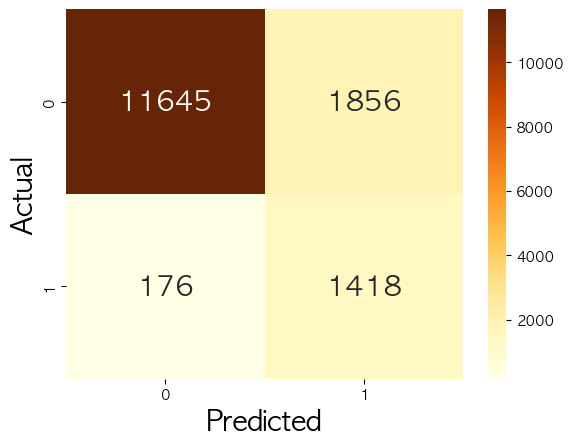

In [27]:
DT(sfm_pi_good)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.923921302777009

예측 데이터 정확도
accuracy score : 0.872
precision score : 0.446
recall score : 0.850
f1 score : 0.585
roc score : 0.863


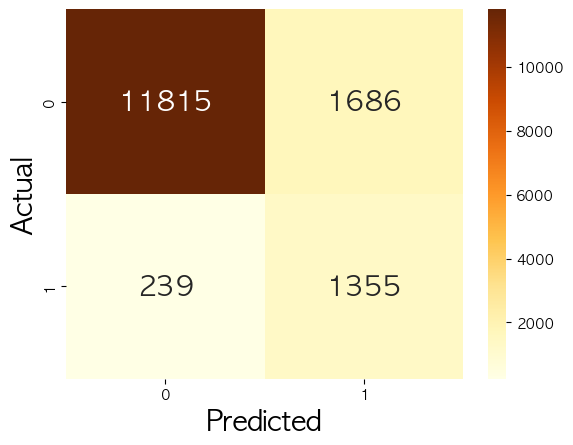

In [28]:
SVM(sfm_pi_good, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.467385850476669, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.9236211338996473

예측 데이터 정확도
accuracy score : 0.864
precision score : 0.434
recall score : 0.935
f1 score : 0.592
roc score : 0.895
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.84207    0.39867 0.97491   0.56591    0.90064
0.30000   0.85088    0.41186 0.96299   0.57696    0.90031
0.40000   0.85737    0.42225 0.95232   0.58508    0.89924
0.50000   0.86419    0.43364 0.93476   0.59245    0.89531
0.60000   0.87049    0.44509 0.91782   0.59947    0.89136
0.70000   0.87804    0.46002 0.89147   0.60688    0.88396
0.80000   0.88811    0.48292 0.84253   0.61394    0.86801
0.90000   0.89990    0.51793 0.75220   0.61346    0.83477
None


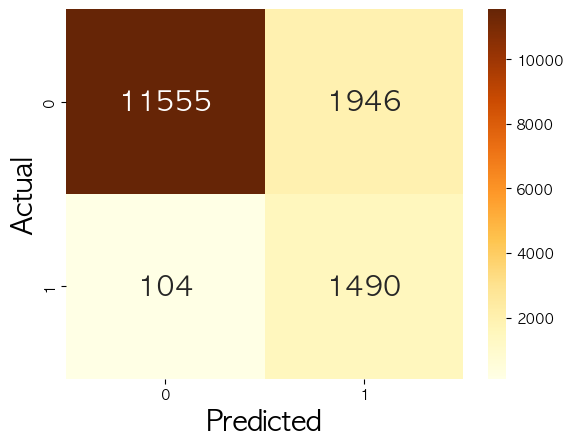

In [29]:
XGB(sfm_pi_good)

#### 수축기

##### Recursive Feature Elimination

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8450693009355763

예측 데이터 정확도
accuracy score : 0.775
precision score : 0.259
recall score : 0.881
f1 score : 0.400
roc score : 0.823
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.46104    0.13497 0.98655   0.23746    0.69937
0.30000   0.60000    0.17168 0.96807   0.29165    0.76692
0.40000   0.70693    0.21726 0.93950   0.35290    0.81240
0.50000   0.77498    0.25851 0.88067   0.39969    0.82291
0.60000   0.82630    0.30051 0.78487   0.43462    0.80752
0.70000   0.85261    0.29434 0.52437   0.37704    0.70375
0.80000   0.87062    0.27857 0.32773   0.30116    0.62441
0.90000   0.88735    0.21701 0.12437   0.15812    0.54133
None


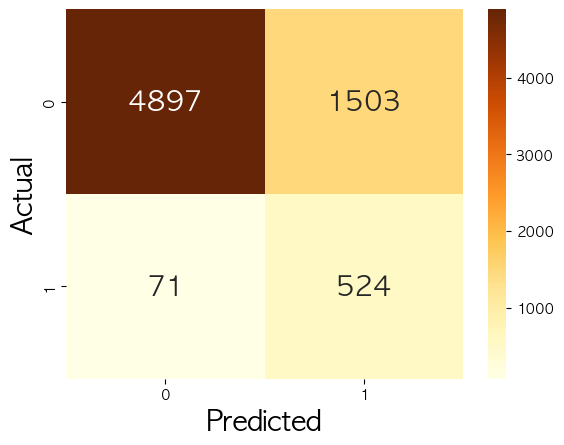

In [30]:
LR(rfe_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9018943020027498

예측 데이터 정확도
accuracy score : 0.833
precision score : 0.321
recall score : 0.869
f1 score : 0.469
roc score : 0.849
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80457    0.29663 0.94622   0.45166    0.86881
0.30000   0.81573    0.30549 0.91597   0.45818    0.86119
0.40000   0.82387    0.31298 0.89580   0.46388    0.85649
0.50000   0.83274    0.32132 0.86891   0.46915    0.84914
0.60000   0.84246    0.32743 0.80840   0.46609    0.82701
0.70000   0.84203    0.32193 0.77479   0.45486    0.81154
0.80000   0.88520    0.34928 0.40504   0.37510    0.66744
0.90000   0.89378    0.36972 0.35294   0.36113    0.64850
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

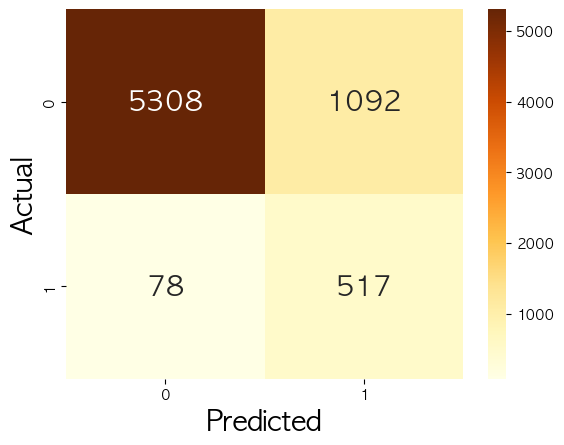

In [31]:
DT(rfe_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8999752975308691

예측 데이터 정확도
accuracy score : 0.832
precision score : 0.317
recall score : 0.850
f1 score : 0.462
roc score : 0.840


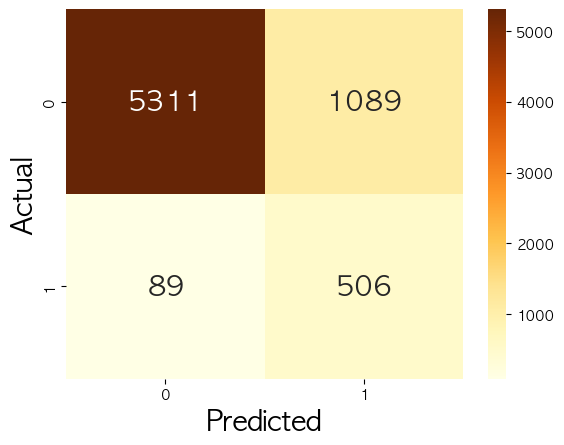

In [32]:
SVM(rfe_bad, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 10.759919300605246, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.909488179325049

예측 데이터 정확도
accuracy score : 0.827
precision score : 0.316
recall score : 0.886
f1 score : 0.466
roc score : 0.854
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80615    0.29900 0.95126   0.45498    0.87196
0.30000   0.81372    0.30571 0.93613   0.46090    0.86924
0.40000   0.82073    0.31096 0.91092   0.46364    0.86163
0.50000   0.82731    0.31614 0.88571   0.46596    0.85379
0.60000   0.83860    0.33037 0.87395   0.47948    0.85463
0.70000   0.84875    0.34284 0.84874   0.48839    0.84874
0.80000   0.85876    0.35325 0.79496   0.48914    0.82982
0.90000   0.87663    0.37862 0.70252   0.49205    0.79767
None


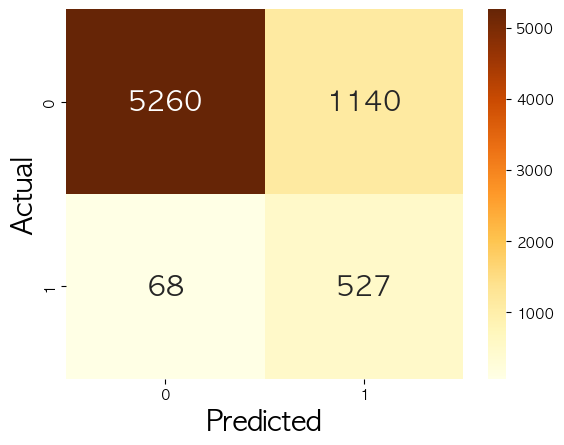

In [33]:
XGB(rfe_bad)

##### SelectFromModel_RandomForest

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8476237934120245

예측 데이터 정확도
accuracy score : 0.784
precision score : 0.266
recall score : 0.874
f1 score : 0.407
roc score : 0.825
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.46390    0.13560 0.98655   0.23842    0.70093
0.30000   0.60129    0.17273 0.97311   0.29339    0.76991
0.40000   0.70965    0.21887 0.93950   0.35503    0.81389
0.50000   0.78370    0.26558 0.87395   0.40736    0.82463
0.60000   0.83402    0.30981 0.77479   0.44263    0.80716
0.70000   0.85919    0.31393 0.55294   0.40049    0.72030
0.80000   0.87448    0.29161 0.33277   0.31083    0.62881
0.90000   0.89092    0.23750 0.12773   0.16612    0.54480
None


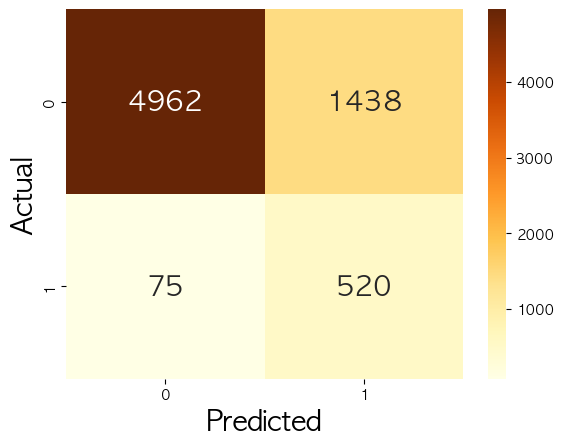

In [34]:
LR(sfm_rf_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9066863518178188

예측 데이터 정확도
accuracy score : 0.831
precision score : 0.322
recall score : 0.887
f1 score : 0.472
roc score : 0.857
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80972    0.30258 0.94790   0.45872    0.87239
0.30000   0.81658    0.30931 0.93782   0.46519    0.87156
0.40000   0.82016    0.31345 0.93613   0.46965    0.87275
0.50000   0.83117    0.32156 0.88739   0.47206    0.85667
0.60000   0.83231    0.32094 0.87059   0.46899    0.84967
0.70000   0.87234    0.37243 0.73109   0.49348    0.80828
0.80000   0.88949    0.40347 0.62521   0.49044    0.76964
0.90000   0.90379    0.44298 0.50924   0.47381    0.72486
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

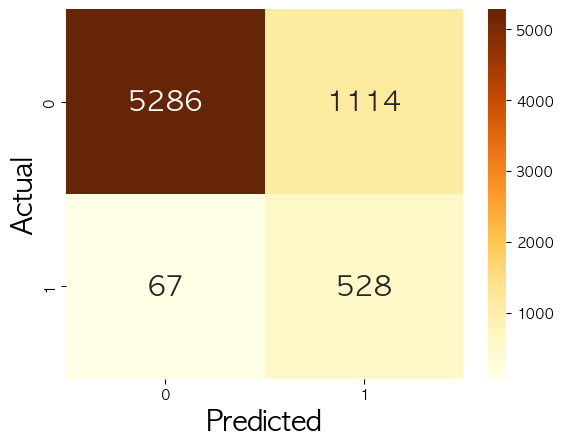

In [35]:
DT(sfm_rf_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.9231378294816125

예측 데이터 정확도
accuracy score : 0.874
precision score : 0.384
recall score : 0.795
f1 score : 0.518
roc score : 0.838


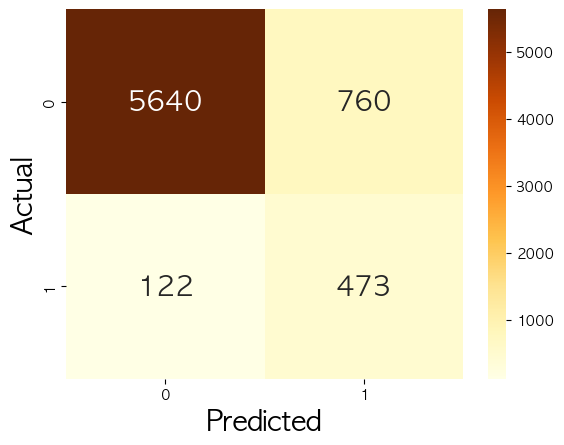

In [36]:
SVM(sfm_rf_bad, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 10.759919300605246, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.9209709494852474

예측 데이터 정확도
accuracy score : 0.855
precision score : 0.356
recall score : 0.872
f1 score : 0.506
roc score : 0.863
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.83259    0.33197 0.95630   0.49285    0.88870
0.30000   0.84003    0.33907 0.92773   0.49663    0.87980
0.40000   0.84846    0.34932 0.90588   0.50421    0.87450
0.50000   0.85490    0.35597 0.87227   0.50560    0.86278
0.60000   0.86376    0.36915 0.84874   0.51452    0.85695
0.70000   0.87305    0.38345 0.81008   0.52052    0.84450
0.80000   0.88406    0.40288 0.75294   0.52490    0.82460
0.90000   0.89979    0.44150 0.67227   0.53298    0.79660
None


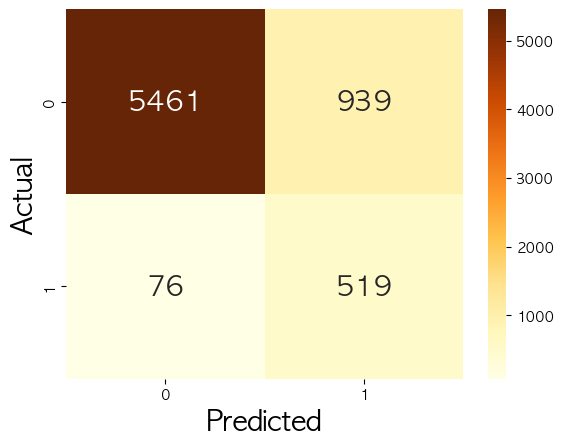

In [37]:
XGB(sfm_rf_bad)

##### SelectFromModel_Logistic Regression

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8327249599312225

예측 데이터 정확도
accuracy score : 0.784
precision score : 0.270
recall score : 0.899
f1 score : 0.415
roc score : 0.836
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.39771    0.12328 0.99496   0.21938    0.66857
0.30000   0.56798    0.16188 0.97647   0.27772    0.75324
0.40000   0.69864    0.21485 0.95798   0.35099    0.81626
0.50000   0.78413    0.26952 0.89916   0.41473    0.83630
0.60000   0.83102    0.29140 0.68908   0.40959    0.76665
0.70000   0.84718    0.24013 0.36807   0.29064    0.62989
0.80000   0.86505    0.20965 0.21176   0.21070    0.56877
0.90000   0.88663    0.20359 0.11429   0.14639    0.53636
None


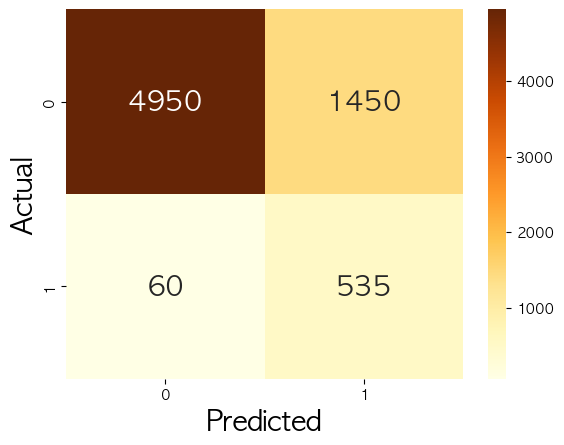

In [38]:
LR(sfm_lr_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.891829737789472

예측 데이터 정확도
accuracy score : 0.798
precision score : 0.291
recall score : 0.956
f1 score : 0.446
roc score : 0.870
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.77670    0.27417 0.98655   0.42909    0.87187
0.30000   0.78142    0.27804 0.98319   0.43349    0.87292
0.40000   0.78342    0.27906 0.97647   0.43407    0.87097
0.50000   0.79828    0.29120 0.95630   0.44645    0.86995
0.60000   0.80486    0.29608 0.93950   0.45026    0.86592
0.70000   0.81716    0.30300 0.88403   0.45131    0.84749
0.80000   0.90007    0.43780 0.61513   0.51153    0.77084
0.90000   0.92223    0.57265 0.33782   0.42495    0.65719
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

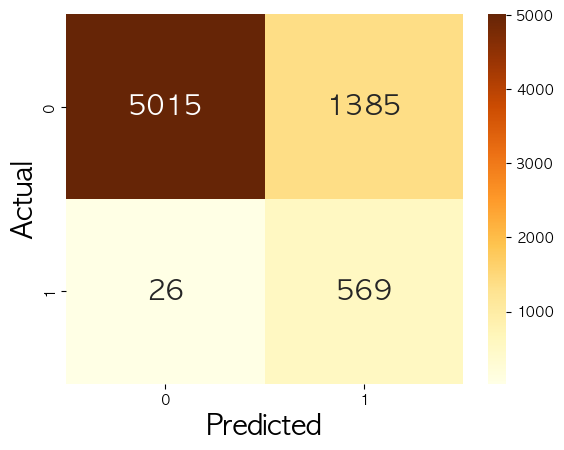

In [39]:
DT(sfm_lr_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.9110536076216267

예측 데이터 정확도
accuracy score : 0.853
precision score : 0.336
recall score : 0.751
f1 score : 0.465
roc score : 0.807


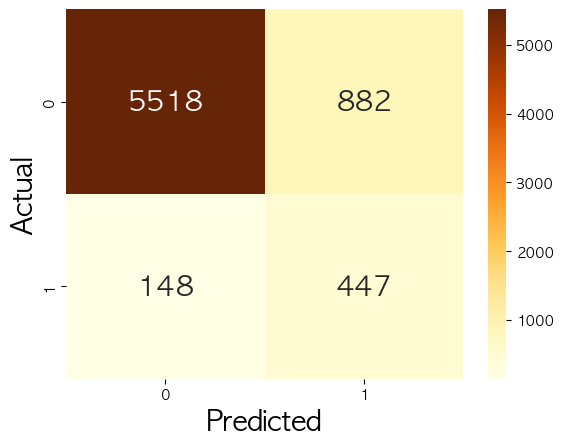

In [40]:
SVM(sfm_lr_bad, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 10.759919300605246, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.9158666601101564

예측 데이터 정확도
accuracy score : 0.832
precision score : 0.321
recall score : 0.877
f1 score : 0.470
roc score : 0.852
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80772    0.29882 0.93613   0.45303    0.86596
0.30000   0.81816    0.30972 0.92605   0.46420    0.86709
0.40000   0.82402    0.31360 0.89916   0.46502    0.85810
0.50000   0.83174    0.32103 0.87731   0.47006    0.85241
0.60000   0.83960    0.32923 0.85378   0.47521    0.84603
0.70000   0.84989    0.34080 0.81849   0.48123    0.83565
0.80000   0.86562    0.36364 0.77311   0.49462    0.82366
0.90000   0.88177    0.38650 0.66387   0.48856    0.78295
None


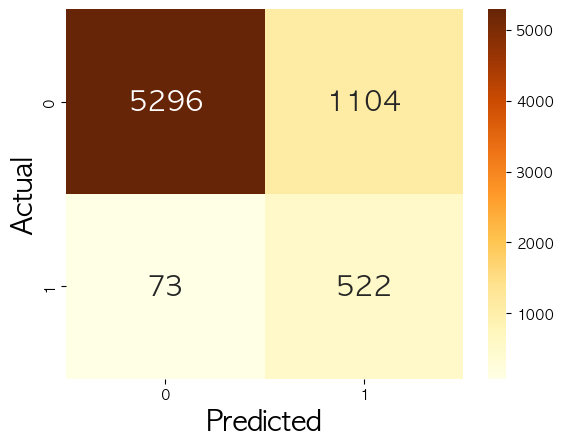

In [41]:
XGB(sfm_lr_bad)

##### Permutation Importance

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8481956532124793

예측 데이터 정확도
accuracy score : 0.784
precision score : 0.265
recall score : 0.872
f1 score : 0.407
roc score : 0.824
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.46333    0.13547 0.98655   0.23823    0.70062
0.30000   0.60143    0.17298 0.97479   0.29382    0.77075
0.40000   0.70979    0.21896 0.93950   0.35515    0.81397
0.50000   0.78356    0.26520 0.87227   0.40674    0.82379
0.60000   0.83345    0.30769 0.76639   0.43909    0.80304
0.70000   0.85861    0.31238 0.55126   0.39878    0.71922
0.80000   0.87420    0.29197 0.33613   0.31250    0.63018
0.90000   0.88978    0.23006 0.12605   0.16287    0.54342
None


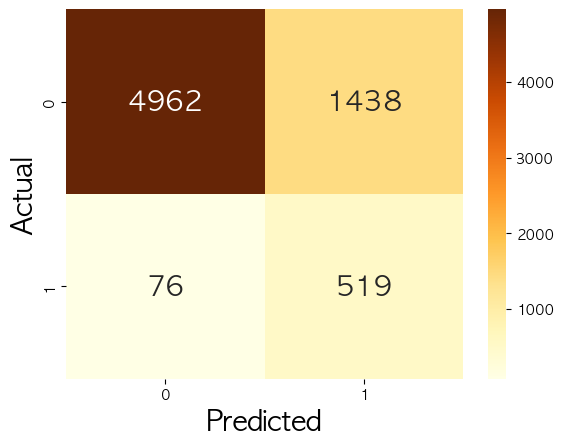

In [42]:
LR(sfm_pi_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9096380013914622

예측 데이터 정확도
accuracy score : 0.845
precision score : 0.335
recall score : 0.834
f1 score : 0.478
roc score : 0.840
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80801    0.30378 0.97311   0.46301    0.88288
0.30000   0.81658    0.30825 0.92941   0.46296    0.86775
0.40000   0.84074    0.33116 0.85546   0.47749    0.84742
0.50000   0.84532    0.33536 0.83361   0.47830    0.84001
0.60000   0.84875    0.33823 0.81345   0.47779    0.83274
0.70000   0.84889    0.33617 0.79664   0.47282    0.82519
0.80000   0.88477    0.35915 0.45210   0.40030    0.68855
0.90000   0.88592    0.36302 0.45210   0.40269    0.68918
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

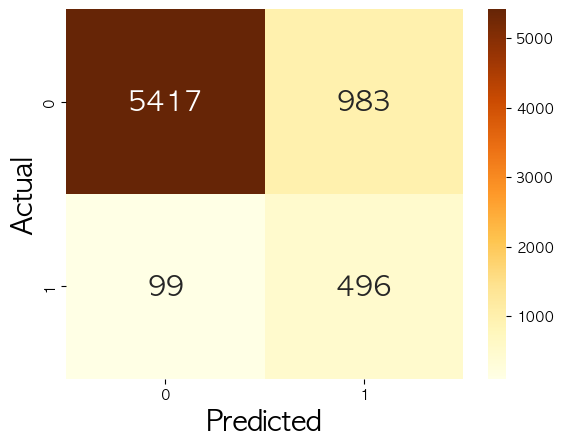

In [43]:
DT(sfm_pi_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.9170696283572249

예측 데이터 정확도
accuracy score : 0.860
precision score : 0.358
recall score : 0.817
f1 score : 0.498
roc score : 0.840


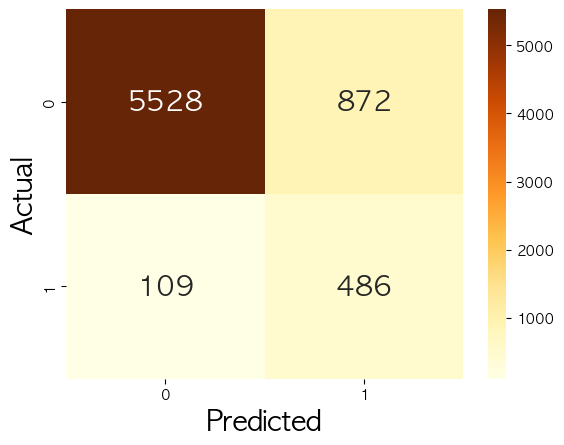

In [44]:
SVM(sfm_pi_bad, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 10.759919300605246, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.9203858987820608

예측 데이터 정확도
accuracy score : 0.855
precision score : 0.357
recall score : 0.889
f1 score : 0.510
roc score : 0.870
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.83202    0.33081 0.95294   0.49112    0.88686
0.30000   0.84089    0.34149 0.93782   0.50067    0.88485
0.40000   0.84732    0.34849 0.91429   0.50464    0.87769
0.50000   0.85461    0.35743 0.88908   0.50988    0.87024
0.60000   0.86219    0.36698 0.85546   0.51362    0.85914
0.70000   0.87119    0.38066 0.82017   0.51998    0.84805
0.80000   0.87977    0.39360 0.76471   0.51970    0.82759
0.90000   0.89207    0.41561 0.66218   0.51069    0.78781
None


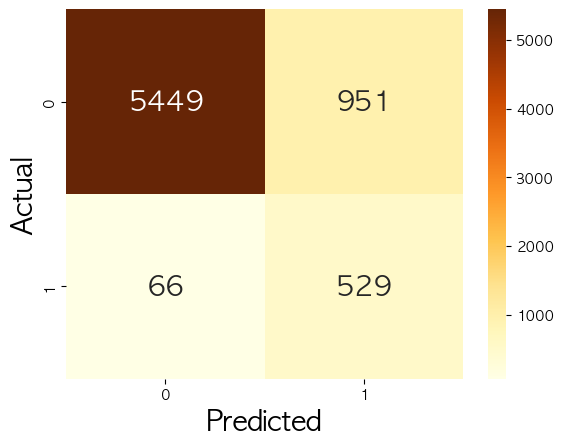

In [45]:
XGB(sfm_pi_bad)